In [1]:
import pandas_datareader as web
from datetime import date
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
%matplotlib inline

In [2]:
def get_dates(data_window):
    '''
    Returns the start date and end date for given number of years

    Parameters:
    data_window (int): number of years of past data

    Returns:
    start_date (datetime): start date
    end_date (datetime): today's date
    '''
    end_date = pd.to_datetime(date.today())
    start_date = pd.to_datetime(
        date.today() + relativedelta(years=-data_window))

    return start_date, end_date

In [3]:
# take a look at stock
data_window = 1  # number of years of historical data to look at
start_date, end_date = get_dates(data_window)
stock = 'SPY'  # stock symbol

df = web.DataReader(stock, data_source='yahoo',
                    start=start_date, end=end_date)
df

High         Low  ...       Volume   Adj Close
Date                                ...                         
2020-03-16  256.899994  237.360001  ...  297240000.0  235.452972
2020-03-17  256.170013  237.070007  ...  262070500.0  248.165558
2020-03-18  248.369995  228.020004  ...  327597100.0  235.600204
2020-03-19  247.380005  232.220001  ...  289322000.0  236.100845
2020-03-20  244.470001  228.500000  ...  347158800.0  225.926285
...                ...         ...  ...          ...         ...
2021-03-08  387.679993  381.420013  ...  122957100.0  381.720001
2021-03-09  389.910004  385.309998  ...  113457800.0  387.170013
2021-03-10  391.399994  388.170013  ...  109660800.0  389.579987
2021-03-11  395.649994  391.739990  ...   86027400.0  393.529999
2021-03-12  394.209991  391.200012  ...   64608100.0  394.059998

[251 rows x 6 columns]

In [4]:
# check for null values
df.isnull().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

Text(0.5, 1.0, 'SPY')

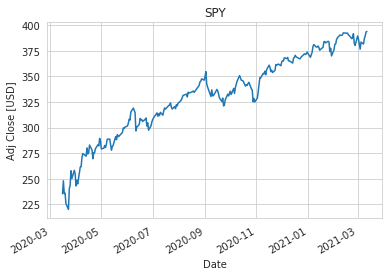

In [5]:
# plot adjusted close
sns.set_style('whitegrid')
df['Adj Close'].plot()
plt.xlabel('Date')
plt.ylabel('Adj Close [USD]')
plt.title(stock)

In [6]:
def plot_prediction(future_days, split_perc=0.80):
    '''
    Plots actual and predicted stock price using LSTM. 
    Provides evaluation metrics as well.

    Parameters:
    future_days (int): number of days lookahead for future value
    split_perc (float): percentage of training data

    Returns:
    None
    '''

    # future value is adjusted close future_days into the future
    df['Future'] = df['Adj Close'].shift(-future_days)

    # scale the data
    cols = list(df.columns)
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df[cols])

    # define features (X) and label (y)
    # number of past days of data to use to make prediction future_days ahead
    past_days = future_days

    X = []
    y = []

    for i in range(past_days, len(df_scaled) - future_days + 1):
        X.append(df_scaled[i - past_days:i, :-1])
        y.append(df_scaled[i - 1, -1])

    split_index = int(len(X) * split_perc)

    # split data into train and test sets
    X_train = np.array(X[:split_index])
    y_train = np.array(y[:split_index])
    X_test = np.array(X[split_index:])
    y_test = np.array(y[split_index:])

    # reshape labels
    y_train = y_train.reshape(y_train.shape[0], 1)
    y_test = y_test.reshape(y_test.shape[0], 1)

    # build the LSTM model
    model = Sequential()
    model.add(LSTM(64, input_shape=(
        X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(16))
    model.add(Dense(y_train.shape[1]))

    # compile model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # fit model
    model.fit(X_train, y_train, epochs=300, batch_size=50, verbose=0)

    # predict on test dataset
    y_pred_transformed = model.predict(X_test)

    # inverse transform
    df_transformed = np.zeros((y_pred_transformed.shape[0], len(cols)))
    df_transformed[:, -
                   1] = y_pred_transformed.reshape(y_pred_transformed.shape[0])
    y_pred = scaler.inverse_transform(df_transformed)[:, -1]

    # store the adjusted close results in a dataframe
    results = pd.DataFrame(
        {'Actual': df['Adj Close'].iloc[split_index+future_days+past_days-1:], 'Predicted': y_pred})

    # evaluation metrics
    lstm_results.loc[future_days, 'Mean Absolute Error'] = metrics.mean_absolute_error(
        results['Actual'], results['Predicted'])
    lstm_results.loc[future_days, 'Root Mean Squared Error'] = np.sqrt(
        metrics.mean_squared_error(results['Actual'], results['Predicted']))

    # plot data
    plt.figure(figsize=(14, 6))
    plt.suptitle('{} day stock price prediction'.format(future_days))

    plt.subplot(1, 2, 1)  # subplot 1
    df['Adj Close'].plot(label='Actual')
    results['Predicted'].plot(label='Predicted')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Adj Close [USD]')
    plt.title(stock)

    plt.subplot(1, 2, 2)  # subplot 2 zoomed in
    df['Adj Close'].iloc[-y_test.shape[0]:].plot(label='Actual')
    results['Predicted'].plot(label='Predicted')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Adj Close [USD]')
    plt.title(stock + ' (closer look at test data)')

    del model

In [7]:
# makes stock price predictions for these days into the future
predictions = [1, 7, 14, 28, 56]
lstm_results = pd.DataFrame(index=predictions, columns=[
    'Mean Absolute Error', 'Root Mean Squared Error'])  # empty dataframe to store results

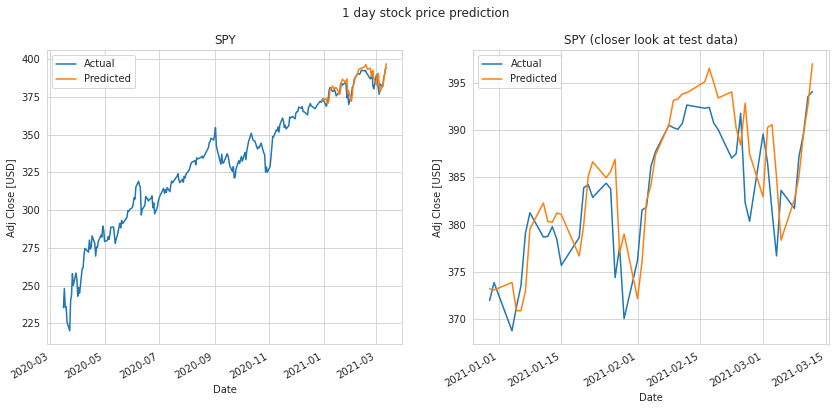

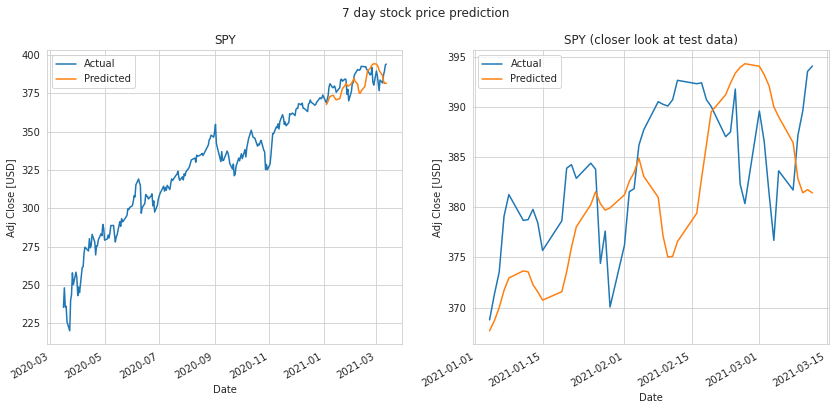

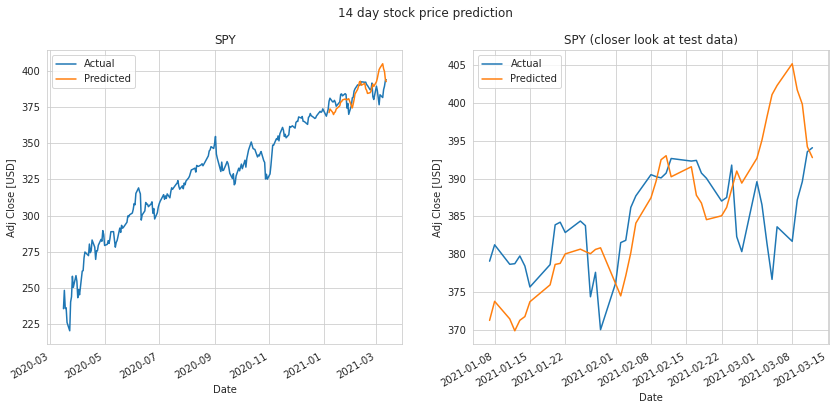

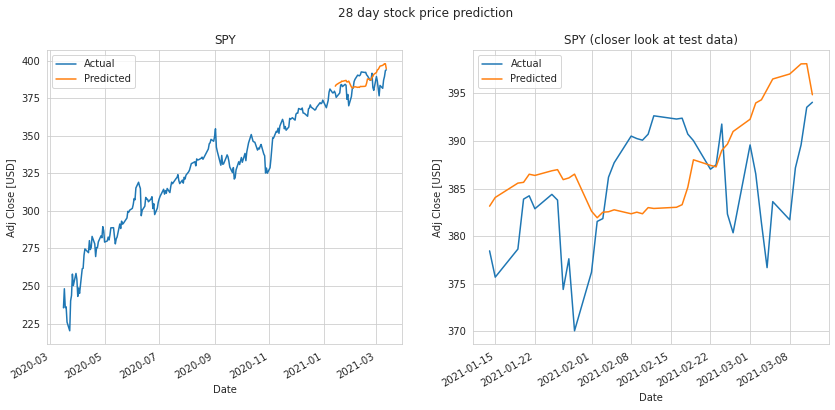

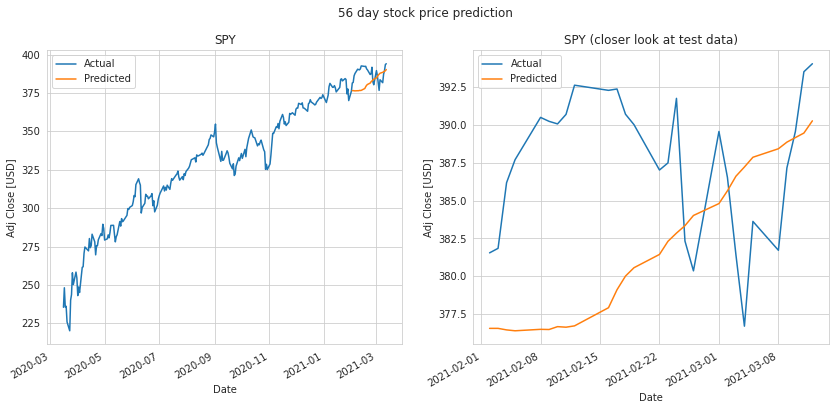

In [8]:
# plot stock price predictions
for future_days in predictions:
    plot_prediction(future_days)

In [9]:
# take a look at the results
lstm_results

Mean Absolute Error Root Mean Squared Error
1              3.50348                 4.51481
7              6.99564                 8.17902
14             6.30276                 8.39999
28             6.70519                 8.10957
56             7.75053                 9.04549

Text(0.5, 1.0, 'SPY')

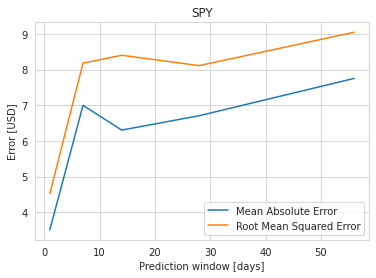

In [10]:
# plot results
lstm_results.plot()
plt.xlabel('Prediction window [days]')
plt.ylabel('Error [USD]')
plt.title(stock)